# Question 1

# Auto Encoder

In [1]:
import numpy as np
import pandas as pd
import sys

In [2]:
data=pd.read_csv("../input_data/intrusion_detection/data.csv")

#store the label and then drop it from original data as autoencoder is unsupervised learning method
target=data['xAttack']
data=data.drop(['xAttack'],axis=1)

columns=['duration','service','src_bytes','dst_bytes','hot','num_failed_logins','num_compromised','num_root','num_file_creations','num_access_files','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

#bring down the data to the range of 0 and 1 as it is convinent in case of auto-encoder
def normalize(data):
    maxs = np.amax(data, axis=0)
    mins = np.amin(data, axis=0)
    
    # Data used for autoencoder
    AEdata = (data - mins) / (maxs - mins)    
    return AEdata

data=normalize(data) 

In [3]:
print np.shape(data)
#In all the autoencoders, the number of nodes in bottleneck layer are equal to the number of reduced dimensions
#you got by using PCA by keeping the tolerance of 10 ====>>> 14
hidden_layer=14
input_layer=29 # defined by dimensions of input data
output_layer=29

(24998, 29)


Functions

In [4]:
def linear_der(x):
    linear_grad = np.ones(x.shape)
    return linear_grad

def linear(x):
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def tanh(x):
    return np.sinh(x)/np.cosh(x)
    
def sigmoid_der(x):
    return sigmoid(x) * (1- sigmoid(x))

def tanh_der(x):
    t=(tanh(x)**2)
    return 1-t

Create mini-batches of the data

In [5]:
def create_minibatches(batch_size,train):
    train_list=train.values
    rows=train.shape[0]
    n = batch_size  #chunk row size batch size
    train_chunks = [train_list[i:i+n] for i in range(0,rows,n)]
    return train_chunks

In [6]:
batch_size=raw_input("Enter Batch Size: ")

Enter Batch Size: 512


In [7]:
data_chunks=create_minibatches(int(batch_size),data)

In [8]:
learning_rate=raw_input("Enter Learning Rate: ")
learning_rate=float(learning_rate)

Enter Learning Rate: 0.0001


In [9]:
import math
class MultipleHiddenLayerNN:
    
    def __init__(self,input_size,output_size,hidden_size,num_of_hidden_layers):
        self.outputLayers = output_size
        self.inputLayers = input_size
        self.numHiddenLayers = num_of_hidden_layers
        self.hiddenLayers = hidden_size
        
        #list of weigths and biases of all the hidden layers
        #weight between i/p layer and hidden layer just next to i/p layer
        self.weights=[]
        
        weight1=np.random.randn(self.inputLayers,self.hiddenLayers)*math.sqrt(2.0/self.inputLayers)
        self.weights.append(weight1)
        
        self.biases=[]
        bias1=np.random.randn(hidden_size)
        self.biases.append(bias1)

        #for n-1 times we need to calculate the weights for itermediate hidden layers
        for i in range(self.numHiddenLayers-1):
            #assuming the size of each itermediate hidden layer to be the same
            self.weights.append(np.random.randn(self.hiddenLayers,self.hiddenLayers)*math.sqrt(2.0/self.hiddenLayers))
            self.biases.append(np.random.randn(hidden_size))

        #weight between the last hidden layer and the output layer
        self.weights.append(np.random.randn(self.hiddenLayers,self.outputLayers)*math.sqrt(2.0/self.hiddenLayers))
        self.biases.append(np.random.randn(output_size))

    def forwardPropagation(self,X,function):
        self.activation_list=[]
        self.training_matrix=X
        self.z2 = np.dot(X,self.weights[0])+self.biases[0]
        self.a2 = function(self.z2)
        self.bottleneck=self.a2
        self.activation_list.append(self.a2)

        for i in range(self.numHiddenLayers-1):
            self.z2=np.dot(self.activation_list[i],self.weights[i+1])+self.biases[i+1]
            self.a2=function(self.z2)
            if i==math.floor((self.numHiddenLayers)/2):
                print " shape : ", np.shape(self.a2)
                self.bottleneck=(self.a2)
            self.activation_list.append(self.a2)

        self.z3=np.dot(self.activation_list[self.numHiddenLayers-1],self.weights[self.numHiddenLayers])+self.biases[self.numHiddenLayers]
        yHat = self.z3
        return yHat

    def backPropagation(self, yHat, yactual, function_der,learning_rate):
        derivative_wgt=[]
        derivative_bias=[]

        #derivative of mean square error 
        cost = (yHat - yactual)
        dOout_dOin = function_der(yHat)
        cost=np.multiply(cost,dOout_dOin)
        
        #propagating backwards from last layer to first
        for l in range(self.numHiddenLayers,0,-1):
            dOin_dw = self.activation_list[l-1]
            wgt_der=np.dot(dOin_dw.T,cost)
            bs_der=np.average(cost,axis=0)
            derivative_wgt.append(wgt_der)
            derivative_bias.append(bs_der)
            cost=np.dot(cost,self.weights[l].T)
            dOout_dOin = function_der(self.activation_list[l-1])
            cost=np.multiply(cost,dOout_dOin)

        derivative_wgt.append(np.dot(self.training_matrix.T,cost))
        derivative_wgt=derivative_wgt[::-1]        
        derivative_bias.append(np.average(cost,axis=0))    
        derivative_bias=derivative_bias[::-1]
        return derivative_wgt,derivative_bias


    def updateWeight(self,wgt,bias,learning_rate):
        for l in range(self.numHiddenLayers + 1):
            self.weights[l]-=learning_rate * wgt[l]
            self.biases[l]-=learning_rate * bias[l].sum(axis=0)

    def calculate_loss(self,yHat,yactual):
        r,c=np.shape(yactual)
        loss=np.square(yactual-yHat)/r
        return loss

# Part-1)

# 3-Layer autoencoder consisting of input , output and bottleneck layers in which 

# a)input and output layers have linear activation functions.

In [10]:
input_size=input_layer
output_size=output_layer
hidden_size=hidden_layer
num=1

In [11]:
AE3layer=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))

In [12]:
def create_error_list(function,multiNN,train_chunks,function_der,learning_rate):
    x_list_multi=[]
    error_list_multi=[]
    reducedDataset=[]
    for i in range(50):
        predicted=np.array([])
        actual_t=np.array([])
        reducedD=np.array([])
        for j in range(len(train_chunks)):
            yHat=multiNN.forwardPropagation(train_chunks[j],function)
            if reducedD.size==0:
                reducedD=multiNN.bottleneck
            else:
#                 print "adding ", np.shape(multiNN.bottleneck)
                reducedD=np.concatenate((reducedD,multiNN.bottleneck),axis=0)
            der_wgt,der_bias=multiNN.backPropagation(yHat,train_chunks[j],function_der,learning_rate)
            multiNN.updateWeight(der_wgt,der_bias,learning_rate)
            predicted=np.vstack([predicted,yHat]) if predicted.size else yHat
            actual_t=np.vstack([actual_t,train_chunks[j]]) if len(actual_t) else train_chunks[j]

        if i%1==0:
            x_list_multi.append(i)
            loss = multiNN.calculate_loss(predicted,actual_t)
#             print loss
            print "Loss function value: ", np.sum(loss)
            error_list_multi.append(np.sum(loss))
            print 
            reducedDataset=np.array(reducedD)   
#             print "rd shape: ",np.shape(reducedDataset)
    return x_list_multi,error_list_multi,reducedDataset

In [13]:
x_axis,error,rd=create_error_list(linear,AE3layer,data_chunks,linear_der,learning_rate)

Loss function value:  5.665587026604652

Loss function value:  1.187234422893036

Loss function value:  0.7710810438282538

Loss function value:  0.5911860257419507

Loss function value:  0.4886782927572879

Loss function value:  0.4228256025129513

Loss function value:  0.3764214739843263

Loss function value:  0.34155574180317755

Loss function value:  0.3142169401191337

Loss function value:  0.29211973334004393

Loss function value:  0.2738233162419247

Loss function value:  0.2583537494519957

Loss function value:  0.2450249939680093

Loss function value:  0.2333426445452436

Loss function value:  0.22294574128145384

Loss function value:  0.21356858649974017

Loss function value:  0.20501446520442435

Loss function value:  0.1971370920373136

Loss function value:  0.18982731797101277

Loss function value:  0.18300349649287984

Loss function value:  0.1766044201500127

Loss function value:  0.17058407361089722

Loss function value:  0.16490768149393129

Loss function value:  0.159

In [14]:
print "Reduced dataset shape: ",np.shape(rd)

Reduced dataset shape:  (24998, 14)


In [15]:
import matplotlib.pyplot as plt
def create_graph(x_list,error_list,name):
    plt.figure(figsize=(5,5))
    plt.title(name)
    plt.plot(x_list,error_list)

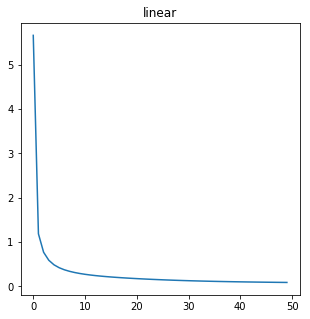

In [16]:
create_graph(x_axis,error,"linear")

# b) Input and output layers layers have non-linear activation functions

In [17]:
AE3layer_sig=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))
x_axis_sig,error_sig,rd_sig=create_error_list(sigmoid,AE3layer_sig,data_chunks,sigmoid_der,learning_rate)

AE3layer_tanh=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))
x_axis_tanh,error_tanh,rd_tanh=create_error_list(tanh,AE3layer_tanh,data_chunks,tanh_der,learning_rate)

Loss function value:  22.231433136793143

Loss function value:  3.0782940940216386

Loss function value:  2.2002552429911515

Loss function value:  2.0225154573233017

Loss function value:  1.8802612409085506

Loss function value:  1.755867715490975

Loss function value:  1.6427662984865652

Loss function value:  1.5381136089143566

Loss function value:  1.44091052396286

Loss function value:  1.3510065425437752

Loss function value:  1.2685354294579638

Loss function value:  1.193600156713728

Loss function value:  1.1261221472066292

Loss function value:  1.0658015985959939

Loss function value:  1.0121461949017632

Loss function value:  0.96453287127662

Loss function value:  0.9222764432780135

Loss function value:  0.8846890297189113

Loss function value:  0.8511231197392887

Loss function value:  0.8209974598369835

Loss function value:  0.7938084586472718

Loss function value:  0.7691311089548133

Loss function value:  0.7466133395628132

Loss function value:  0.7259669608111072

Reduced dataset shape for sigmoid:  (24998, 14)


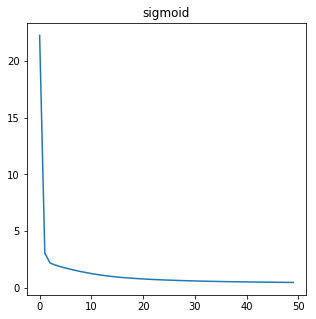

In [18]:
create_graph(x_axis_sig,error_sig,"sigmoid")
print "Reduced dataset shape for sigmoid: ",np.shape(rd_sig)

Reduced dataset shaape for tanh:  (24998, 14)


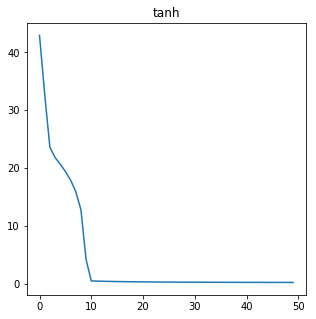

In [19]:
create_graph(x_axis_tanh,error_tanh,"tanh")
print "Reduced dataset shaape for tanh: ",np.shape(rd_tanh)

# Deep Autoencoders where you increase the number of hidden layers and use non-linear activation functions.

In [20]:
import math
class DeepAutoEncoder:
    
    def __init__(self,input_size,output_size,hidden_layer_sizes,num_of_hidden_layers):
        self.outputLayers = output_size
        self.inputLayers = input_size
        self.numHiddenLayers = num_of_hidden_layers
        self.hiddenLayers = hidden_layer_sizes
        
        #list of weigths and biases of all the hidden layers
        #weight between i/p layer and hidden layer just next to i/p layer
        self.weights=[]
        weight1=np.random.randn(self.inputLayers,self.hiddenLayers[0])*math.sqrt(2.0/self.inputLayers)
        self.weights.append(weight1)
        self.biases=[]
        bias1=np.random.randn(hidden_layer_sizes[0])
        self.biases.append(bias1)

        #for n-1 times we need to calculate the weights for itermediate hidden layers
        for i in range(self.numHiddenLayers-1):
            #assuming the size of each itermediate hidden layer to be the same
            self.weights.append(np.random.randn(self.hiddenLayers[i],self.hiddenLayers[i+1])*math.sqrt(2.0/self.hiddenLayers[i]))
            self.biases.append(np.random.randn(hidden_layer_sizes[i+1]))

        #weight between the last hidden layer and the output layer
        self.weights.append(np.random.randn(self.hiddenLayers[self.numHiddenLayers-1],self.outputLayers)*math.sqrt(2.0/self.hiddenLayers[self.numHiddenLayers-1]))
        self.biases.append(np.random.randn(output_size))

    def forwardPropagation(self,X,function):
        self.activation_list=[]
        self.training_matrix=X
        self.z2 = np.dot(X,self.weights[0])+self.biases[0]
        self.a2 = function(self.z2)
        self.bottleneck=self.a2
        self.activation_list.append(self.a2)

        for i in range(self.numHiddenLayers-1):
            self.z2=np.dot(self.activation_list[i],self.weights[i+1])+self.biases[i+1]
            self.a2=function(self.z2)
            if i==math.ceil((self.numHiddenLayers)/2)-1:
#                 print "entered for ",i,self.hiddenLayers[i] 
#                 print "bottleneck shape: ",np.shape(self.a2)
                self.bottleneck=(self.a2)
            self.activation_list.append(self.a2)

        self.z3=np.dot(self.activation_list[self.numHiddenLayers-1],self.weights[self.numHiddenLayers])+self.biases[self.numHiddenLayers]
        yHat = self.z3
        return yHat
    
    def backPropagation(self, yHat, yactual, function_der,learning_rate):
        derivative_wgt=[]
        derivative_bias=[]

        #derivative of mean square error 
        cost = (yHat - yactual)
        dOout_dOin = function_der(yHat)
        cost=np.multiply(cost,dOout_dOin)
        
        #propagating backwards from last layer to first
        for l in range(self.numHiddenLayers,0,-1):
            dOin_dw = self.activation_list[l-1]
            wgt_der=np.dot(dOin_dw.T,cost)
            bs_der=np.average(cost,axis=0)
            derivative_wgt.append(wgt_der)
            derivative_bias.append(bs_der)
            cost=np.dot(cost,self.weights[l].T)
            dOout_dOin = function_der(self.activation_list[l-1])
            cost=np.multiply(cost,dOout_dOin)

        derivative_wgt.append(np.dot(self.training_matrix.T,cost))
        derivative_wgt=derivative_wgt[::-1]        
        derivative_bias.append(np.average(cost,axis=0))    
        derivative_bias=derivative_bias[::-1]
        return derivative_wgt,derivative_bias


    def updateWeight(self,wgt,bias,learning_rate):
        for l in range(self.numHiddenLayers + 1):
            self.weights[l]-=learning_rate * wgt[l]
            self.biases[l]-=learning_rate * bias[l].sum(axis=0)

    def calculate_loss(self,yHat,yactual):
        r,c=np.shape(yactual)
        loss=np.square(yactual-yHat)/r
        return loss

In [21]:
input_size=raw_input("Enter input layer size: ")
output_size=raw_input("Enter output layer size: ")
num_of_hidden_layers=raw_input("Enter number of hidden layers: ")
hidden_layer_sizes=[]
print "Enter sizes of hidden layers: "
for i in range(int(num_of_hidden_layers)):
    x=raw_input("layer "+str(i)+" : ")
    hidden_layer_sizes.append(int(x))


Enter input layer size: 29
Enter output layer size: 29
Enter number of hidden layers: 3
Enter sizes of hidden layers: 
layer 0 : 20
layer 1 : 14
layer 2 : 20


In [22]:
deepAE = DeepAutoEncoder(int(input_size),int(output_size),hidden_layer_sizes,int(num_of_hidden_layers))

In [23]:
x_axis_deep,error_deep,rd_deep=create_error_list(sigmoid,deepAE,data_chunks,sigmoid_der,learning_rate)

Loss function value:  11.563355567904974

Loss function value:  2.366093465237376

Loss function value:  2.3330975427047163

Loss function value:  2.3285536854278295

Loss function value:  2.324243520769019

Loss function value:  2.3201080123210445

Loss function value:  2.3161182643221108

Loss function value:  2.3122481921035662

Loss function value:  2.3084738223981884

Loss function value:  2.304772889105171

Loss function value:  2.301124488685605

Loss function value:  2.297508777609629

Loss function value:  2.293906702348905

Loss function value:  2.2902997542354115

Loss function value:  2.286669742755026

Loss function value:  2.2829985817771887

Loss function value:  2.2792680839121098

Loss function value:  2.2754597586847267

Loss function value:  2.271554610556486

Loss function value:  2.2675329330399845

Loss function value:  2.2633740952589188

Loss function value:  2.259056317323335

Loss function value:  2.254556430832397

Loss function value:  2.2498496206968843

Lo

Reduced dataset shaape for deep autoencoder using sigmoid:  (24998, 14)


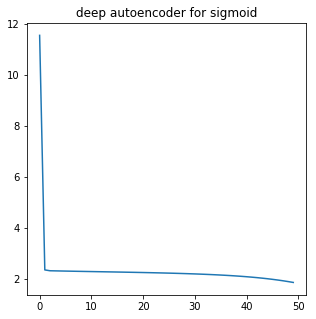

In [24]:
create_graph(x_axis_deep,error_deep,"deep autoencoder for sigmoid")
print "Reduced dataset shaape for deep autoencoder using sigmoid: ",np.shape(rd_deep)

# Part-2)

# Use the reduced dimensions from all the techniques in the first part and perform K-means clustering with k equal to five(number of classes in the data). Also calculate the purity of clusters with given class label.

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(rd)#use the data from auto encoder(reduced one)
y_kmeans = kmeans.predict(rd)

# plt.scatter(rd_sig[:, 0], rd_sig[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
labels = kmeans.labels_
# print labels.tolist()

# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
final_data=pd.DataFrame(rd)
final_data['xAttack']=target
final_data['clusters']=labels

In [26]:
def kmeans(final_data):
    purity_kmeans=[]
    for i in range(5):
        normal=0
        dos=0
        probe=0
        r2l=0
        u2l=0
        total=0
        for index,row in final_data.iterrows():
            if row['clusters']==i:

                if row['xAttack']=='normal':
                    normal+=1

                if row['xAttack']=='dos':
                    dos+=1

                if row['xAttack']=='probe':
                    probe+=1

                if row['xAttack']=='r2l':
                    r2l+=1

                if row['xAttack']=='u2r':
                    u2l+=1
                temp=[]

                total=normal+dos+probe+r2l+u2l
        temp.append((float(normal)/total)*100)
        temp.append((float(dos)/total)*100)
        temp.append((float(probe)/total)*100)
        temp.append((float(r2l)/total)*100)
        temp.append((float(u2l)/total)*100)
        purity_kmeans.append(temp)
        print "for cluster ",i
        print "normal purity: ",(float(normal)/total)*100
        print "dos purity: ",(float(dos)/total)*100
        print "probe purity: ",(float(probe)/total)*100
        print "r2l purity: ",(float(r2l)/total)*100
        print "u2r purity: ",(float(u2l)/total)*100
        print 

    return purity_kmeans

print "k_means (3 layer auto encoder(linear function))-----Purity level"
purity_kmeans=kmeans(final_data)

k_means (3 layer auto encoder(linear function))-----Purity level
for cluster  0
normal purity:  0.29073993313
dos purity:  98.8515772641
probe purity:  0.857682802733
r2l purity:  0.0
u2r purity:  0.0

for cluster  1
normal purity:  67.3920673921
dos purity:  8.96805896806
probe purity:  20.4984204984
r2l purity:  2.96595296595
u2r purity:  0.1755001755

for cluster  2
normal purity:  2.49363867684
dos purity:  69.1094147583
probe purity:  28.3969465649
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  94.8272206911
dos purity:  4.62158151367
probe purity:  0.360398558406
r2l purity:  0.190799236803
u2r purity:  0.0

for cluster  4
normal purity:  49.8043052838
dos purity:  0.880626223092
probe purity:  48.3365949119
r2l purity:  0.978473581213
u2r purity:  0.0



In [27]:
print "deep auto encoder (sigmoid function)"
final_data_deep=pd.DataFrame(rd_deep)
final_data_deep['xAttack']=target
final_data_deep['clusters']=labels

print "k_means (deep auto encoder (sigmoid function))-----Purity level"
purity_kmeans_deep=kmeans(final_data_deep)

deep auto encoder (sigmoid function)
k_means (deep auto encoder (sigmoid function))-----Purity level
for cluster  0
normal purity:  0.29073993313
dos purity:  98.8515772641
probe purity:  0.857682802733
r2l purity:  0.0
u2r purity:  0.0

for cluster  1
normal purity:  67.3920673921
dos purity:  8.96805896806
probe purity:  20.4984204984
r2l purity:  2.96595296595
u2r purity:  0.1755001755

for cluster  2
normal purity:  2.49363867684
dos purity:  69.1094147583
probe purity:  28.3969465649
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  94.8272206911
dos purity:  4.62158151367
probe purity:  0.360398558406
r2l purity:  0.190799236803
u2r purity:  0.0

for cluster  4
normal purity:  49.8043052838
dos purity:  0.880626223092
probe purity:  48.3365949119
r2l purity:  0.978473581213
u2r purity:  0.0



In [28]:
def plot_pie_graph(labels,values,cluster):
    colors = ['lightblue', 'green', 'yellow', 'purple', 'red']
    y=np.array(values)
    legends = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, y)]
    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, labels = ax.pie(y, colors=colors, shadow=True, startangle=90)
    ax.set_title("cluster: "+str(cluster))
    wedges, legends, dummy =  zip(*sorted(zip(wedges, legends, y),
                                          key=lambda x: x[2],
                                          reverse=True))

    ax.legend(wedges, legends, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)


target_labels=['normal','dos','probe','r2l','u2r']
clust=[0,1,2,3,4]

# Part-3 (15 points)

# Perform GMM (with five Gaussian) on the reduced dimensions from first part and calculate the purity of clusters. You can use python library for GMM

In [29]:
from sklearn.mixture import GaussianMixture as GMM

def calculateGMM(data):
    gmm = GMM(n_components=5).fit(data)
    labels = gmm.predict(data)
    return labels

def gmm_func(rd):
    data=pd.DataFrame(rd)

    clusters_for_gmm=calculateGMM(data)

    data['clusters']=clusters_for_gmm
    data['xAttack']=target


    purity_gmm=[]
    for i in range(5):
        temp=[]
        normal=0
        dos=0
        probe=0
        r2l=0
        u2l=0
        total=0
        for index,row in data.iterrows():
            if row['clusters']==i:

                if row['xAttack']=='normal':
                    normal+=1

                if row['xAttack']=='dos':
                    dos+=1

                if row['xAttack']=='probe':
                    probe+=1

                if row['xAttack']=='r2l':
                    r2l+=1

                if row['xAttack']=='u2r':
                    u2l+=1
                temp=[]

                total=normal+dos+probe+r2l+u2l
        temp.append((float(normal)/total)*100)
        temp.append((float(dos)/total)*100)
        temp.append((float(probe)/total)*100)
        temp.append((float(r2l)/total)*100)
        temp.append((float(u2l)/total)*100)
        purity_gmm.append(temp)
        print "for cluster ",i
        print "normal purity: ",(float(normal)/total)*100
        print "dos purity: ",(float(dos)/total)*100
        print "probe purity: ",(float(probe)/total)*100
        print "r2l purity: ",(float(r2l)/total)*100
        print "u2r purity: ",(float(u2l)/total)*100
        print 

    return  purity_gmm

print "GMM (3 layer auto encoder(linear function))-----Purity level"
purity_gmm=gmm_func(rd)

GMM (3 layer auto encoder(linear function))-----Purity level
for cluster  0
normal purity:  97.7537212449
dos purity:  2.24627875507
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  1
normal purity:  0.0
dos purity:  81.3200498132
probe purity:  18.6799501868
r2l purity:  0.0
u2r purity:  0.0

for cluster  2
normal purity:  0.0
dos purity:  100.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  51.6235100699
dos purity:  26.6748869708
probe purity:  19.6465269215
r2l purity:  2.03452527744
u2r purity:  0.0205507603781

for cluster  4
normal purity:  73.1304172546
dos purity:  3.4065712558
probe purity:  21.3061882685
r2l purity:  1.97540818383
u2r purity:  0.181415037291



In [30]:
print "GMM (deep auto encoder (sigmoid function))-----Purity level"
purity_gmm_deep=gmm_func(rd_deep)

GMM (deep auto encoder (sigmoid function))-----Purity level
for cluster  0
normal purity:  0.0
dos purity:  100.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  1
normal purity:  87.0857007576
dos purity:  1.79924242424
probe purity:  9.765625
r2l purity:  1.32575757576
u2r purity:  0.0236742424242

for cluster  2
normal purity:  0.473321858864
dos purity:  58.4767641997
probe purity:  41.0499139415
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  62.52
dos purity:  21.96
probe purity:  15.0
r2l purity:  0.48
u2r purity:  0.04

for cluster  4
normal purity:  82.3824567924
dos purity:  13.175989593
probe purity:  2.9548411076
r2l purity:  1.35662516261
u2r purity:  0.13008734436



# Part-4: (15 points) 


# Perform Hierarchical clustering with single-linkage and five clusters on the reduced dimensions from all the techniques in the first part and calculate the purity of clusters.You can use python library for hierarchical clustering.

In [31]:
newData=pd.DataFrame(rd)
newDataDeep=pd.DataFrame(rd_deep)

set([0, 1, 2, 3, 4])


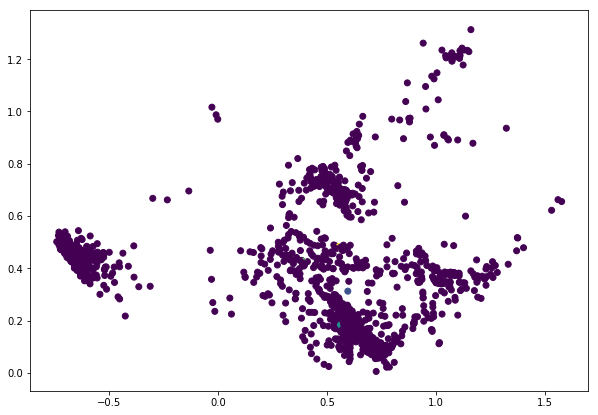

In [32]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single') 
temp=newData.values
test = temp[:2000,0:14]
clusters_hierarchical=cluster.fit_predict(test)  
print set(clusters_hierarchical)
plt.figure(figsize=(10, 7))  
plt.scatter(test[:,0], test[:,1], c=cluster.labels_)

In [33]:
cluster_deep = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single') 
temp_deep=newDataDeep.values
test_deep = temp_deep[:2000,0:14]
clusters_hierarchical_deep=cluster_deep.fit_predict(test_deep)  

In [34]:
def hierarchical(data,clusters_hierarchical,target):
    t=data.values
    t=t[:2000,0:14]
    data=pd.DataFrame(t)
    data['clusters']=clusters_hierarchical
    data['xAttack']=target

    purity=[]
    for i in range(5):
        temp=[]
        normal=0
        dos=0
        probe=0
        r2l=0
        u2l=0
        total=0
        for index,row in data.iterrows():
            if row['clusters']==i:

                if row['xAttack']=='normal':
                    normal+=1

                if row['xAttack']=='dos':
                    dos+=1

                if row['xAttack']=='probe':
                    probe+=1

                if row['xAttack']=='r2l':
                    r2l+=1

                if row['xAttack']=='u2r':
                    u2l+=1
                temp=[]

                total=normal+dos+probe+r2l+u2l
        
        temp.append((float(normal)/total)*100)
        temp.append((float(dos)/total)*100)
        temp.append((float(probe)/total)*100)
        temp.append((float(r2l)/total)*100)
        temp.append((float(u2l)/total)*100)
        purity.append(temp)
        print "for cluster ",i
        print "normal purity: ",(float(normal)/total)*100
        print "dos purity: ",(float(dos)/total)*100
        print "probe purity: ",(float(probe)/total)*100
        print "r2l purity: ",(float(r2l)/total)*100
        print "u2r purity: ",(float(u2l)/total)*100
        print 
    return purity
        
print "hierarchical clustering (3 layer auto encoder(linear function))-----Purity level"
purity=hierarchical(newData,clusters_hierarchical,target)


hierarchical clustering (3 layer auto encoder(linear function))-----Purity level
for cluster  0
normal purity:  55.1102204409
dos purity:  34.9699398798
probe purity:  9.06813627255
r2l purity:  0.801603206413
u2r purity:  0.0501002004008

for cluster  1
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  2
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  4
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0



In [35]:
print "hierarchical clustering (deep auto encoder (sigmoid function))-----Purity level"
purity_deep=hierarchical(newDataDeep,clusters_hierarchical_deep,target)

hierarchical clustering (deep auto encoder (sigmoid function))-----Purity level
for cluster  0
normal purity:  74.5953553835
dos purity:  12.2448979592
probe purity:  11.9634060521
r2l purity:  1.12596762843
u2r purity:  0.0703729767769

for cluster  1
normal purity:  85.1063829787
dos purity:  0.0
probe purity:  14.8936170213
r2l purity:  0.0
u2r purity:  0.0

for cluster  2
normal purity:  0.377358490566
dos purity:  98.8679245283
probe purity:  0.754716981132
r2l purity:  0.0
u2r purity:  0.0

for cluster  3
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0

for cluster  4
normal purity:  100.0
dos purity:  0.0
probe purity:  0.0
r2l purity:  0.0
u2r purity:  0.0



# Part-5: (5 points) 

# Create a pie chart comparing purity of different clustering methods you have tried for all classes for the different autoencoders.

				**********k_means (3 layer auto encoder(linear function))**********	


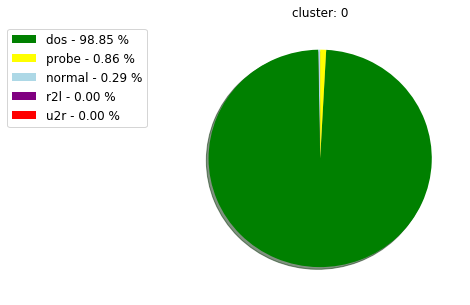

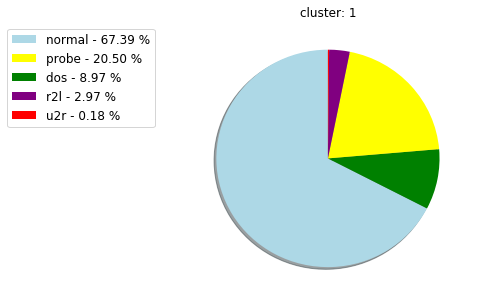

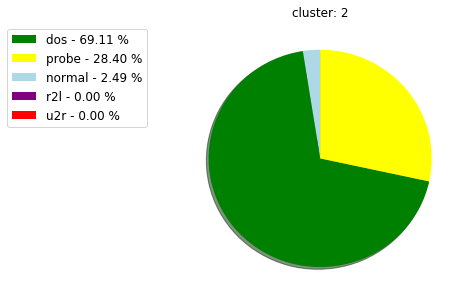

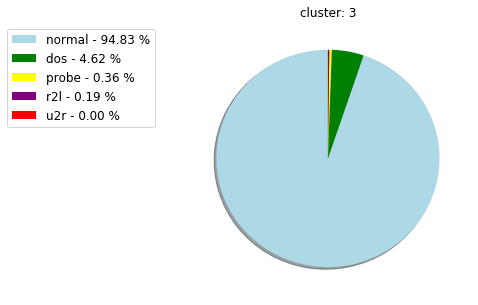

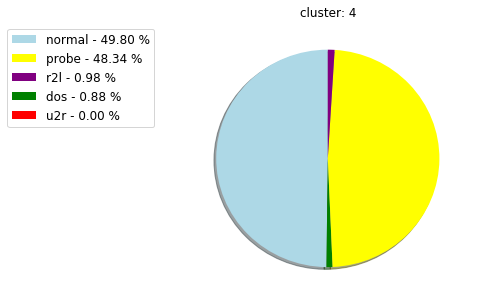

In [36]:
print "\t\t\t\t**********k_means (3 layer auto encoder(linear function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity_kmeans[i],clust[i])

				**********k_means (deep auto encoder (sigmoid function))**********	


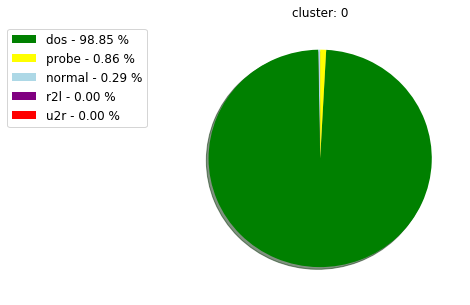

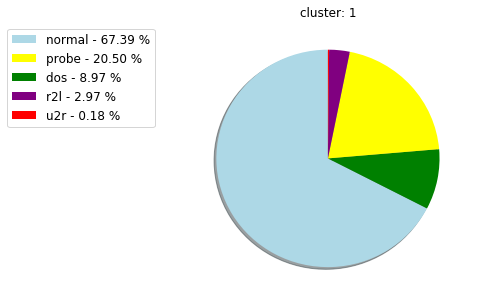

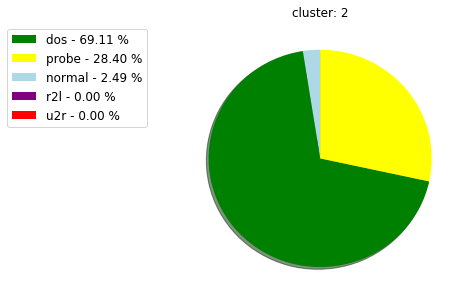

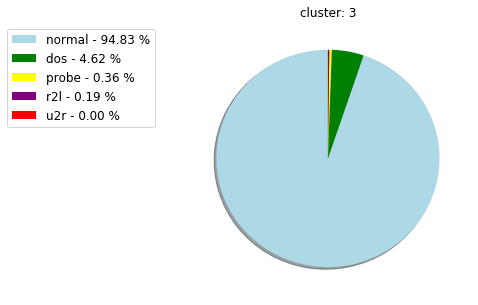

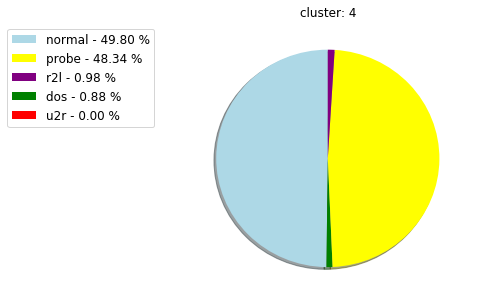

In [37]:
print "\t\t\t\t**********k_means (deep auto encoder (sigmoid function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity_kmeans_deep[i],clust[i])


				**********GMM (3 layer auto encoder(linear function))**********	


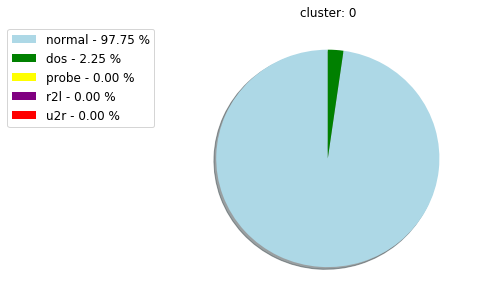

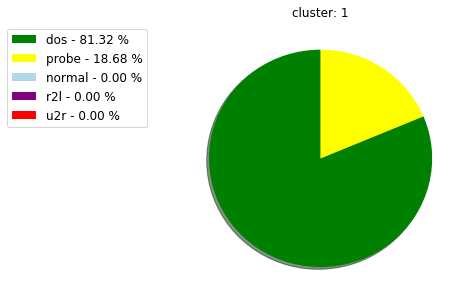

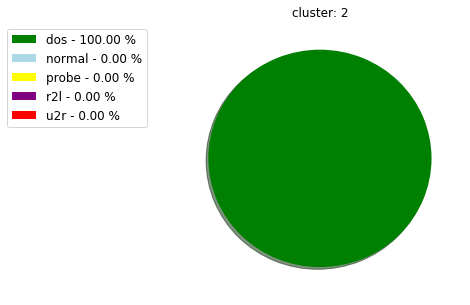

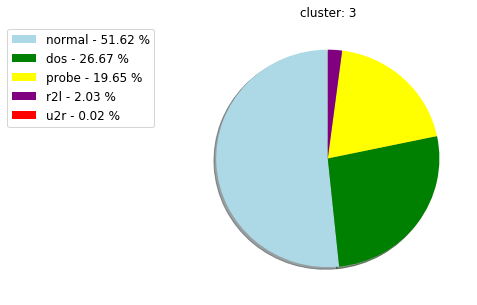

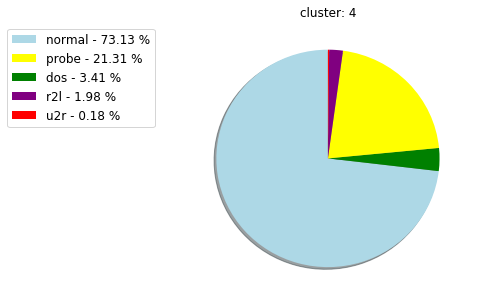

In [38]:
print "\t\t\t\t**********GMM (3 layer auto encoder(linear function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity_gmm[i],clust[i])


				**********GMM (deep auto encoder (sigmoid function))**********	


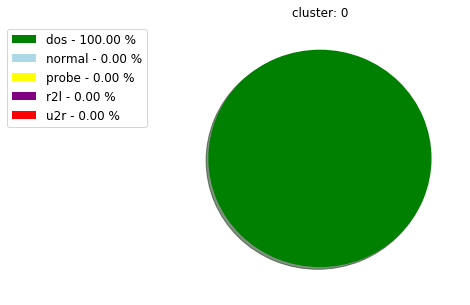

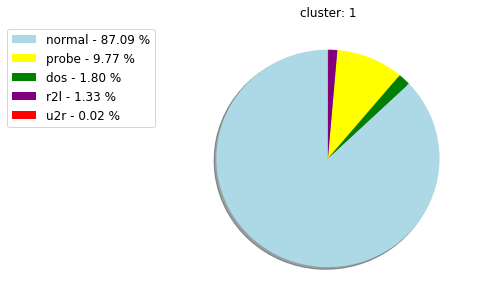

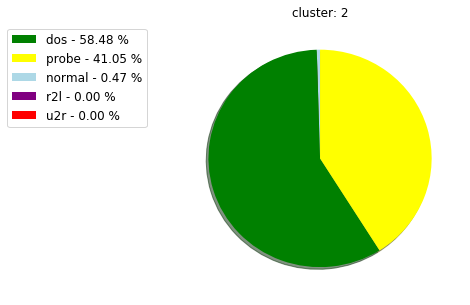

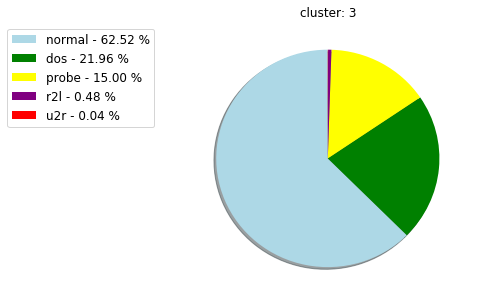

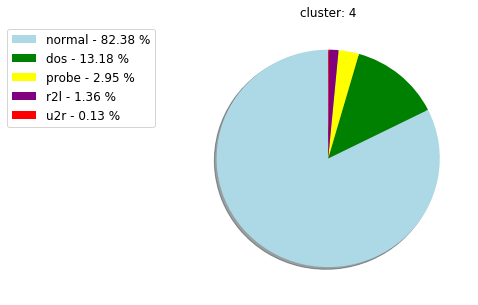

In [39]:
print "\t\t\t\t**********GMM (deep auto encoder (sigmoid function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity_gmm_deep[i],clust[i])

			  **********Hierarchical Custering (3 layer auto encoder(linear function))**********	


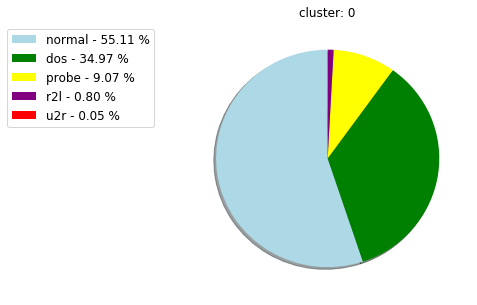

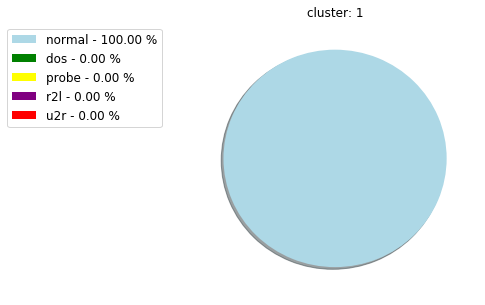

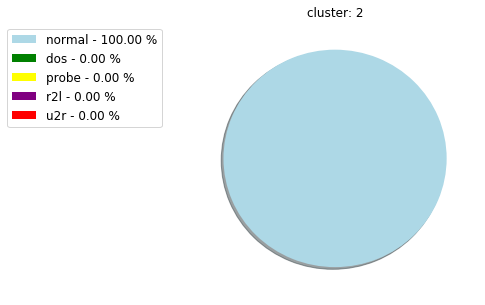

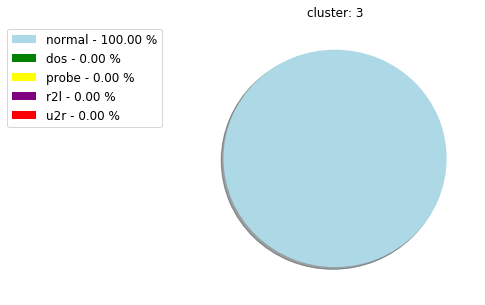

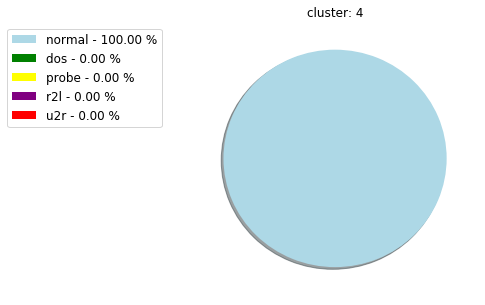

In [40]:
print "\t\t\t  **********Hierarchical Custering (3 layer auto encoder(linear function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity[i],clust[i])
    

			  **********Hierarchical Custering (deep auto encoder (sigmoid function))**********	


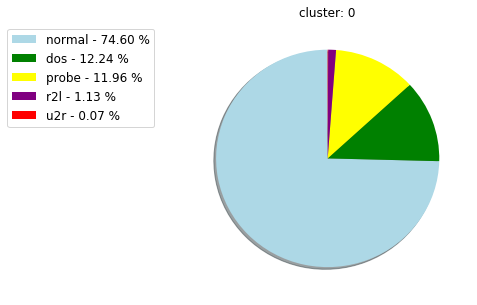

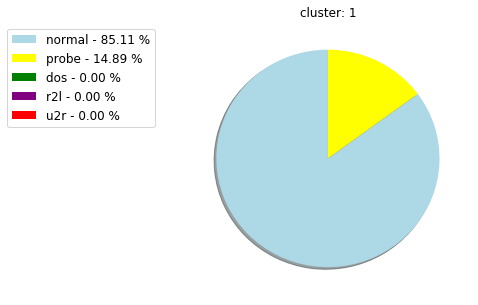

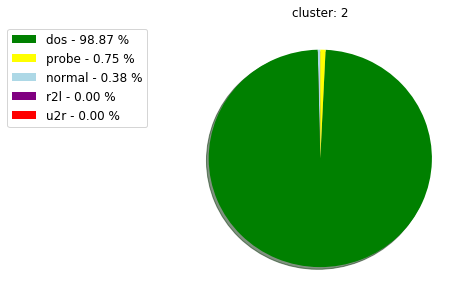

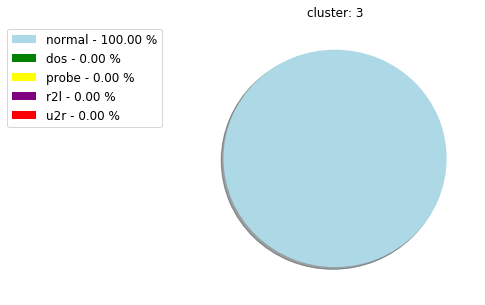

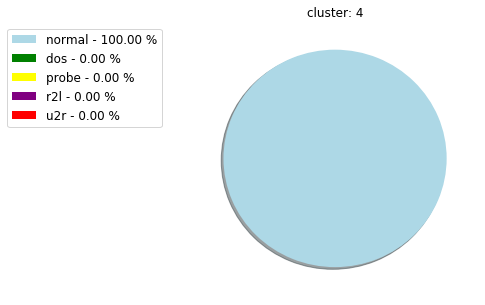

In [41]:
print "\t\t\t  **********Hierarchical Custering (deep auto encoder (sigmoid function))**********\t"
for i in range(5):
    plot_pie_graph(target_labels,purity_deep[i],clust[i])